In [43]:
import time
import random
import csv
import numpy as np
import pandas as pd
from itertools import chain
from pdp_lib import processing as proc
from pdp_lib import util
from GA_lib import GA_multi_depot as GA
from GA_lib import operation_multi_depot as operation
from GA_lib import evaluate_multi_depot as evaluate


In [32]:
def solve_and_print(filename,rounds = 2,population_size = 100,generations=2000,crossoverRate=1.0,mutationRate=0.5):
    process_time = time.time()
    numVehicles, LoadCapacities, speed, data = proc.load_file(filename)
    LOCATIONS = data[0]
    DEMANDS = data[1]
    timeWindows = data[2]
    serviceTimes = data[3]
    pickupSiblings = data[4]
    deliverySiblings = data[5]
    requestType = data[6]
    REQS_TO_SOLVE = proc.generate_request(pickupSiblings, deliverySiblings, requestType)
    DISTANCES = proc.createDistanceTable(LOCATIONS)
    DURATIONS = proc.createDurationTable(LOCATIONS, DISTANCES, serviceTimes, speed)
    DEPOTS = proc.create_depots(LOCATIONS)
    DISTANCES_FROM_DEPOTS = proc.distances_from_depots(DEPOTS, LOCATIONS)
    DISTANCES_TO_DEPOTS = proc.distances_to_depots(DEPOTS, LOCATIONS)
    DEPOT_NUMBERS = proc.simple_assign_depots(REQUESTS, LOCATIONS, DEPOTS, DISTANCES_FROM_DEPOTS, DISTANCES_TO_DEPOTS)
    REQ_BY_DEPOTS = proc.requests_by_depots(DEPOTS, REQUESTS, DEPOT_NUMBERS)

    print('----------------Instance name: '+str(filename)+'-----------------------------------')
    print(" processing time --- %s seconds ---" % (time.time() - process_time))

    total_results = []
    for round in range(rounds):
        results_all_depots = []
        distance_all_depots = []
        time_all_depots = []
        print('#################### Round :' +str(round+1)+' ############################')
        for id_depot in range(len(DEPOTS)):
            THIS_DEP_REQS = REQ_BY_DEPOTS[id_depot]
            NODES_OF_THIS_DEPOT = proc.locations_of_this_depot(id_depot, REQ_BY_DEPOTS, LOCATIONS)
            # ############### SOLVING THE PROBLEMS !!!!!!!! ######################################
            pops_create_time = time.time()
            calculation_time = time.time()
            # print('#################### DEPOT :' +str(id_depot)+' ############################')
            ## Initialize the populations
            populations = []
            for _ in range(population_size):
                chromosome = GA.initialize_Feasible_chromosome(DISTANCES, DISTANCES_FROM_DEPOTS, DISTANCES_TO_DEPOTS, id_depot, DURATIONS, timeWindows, THIS_DEP_REQS, DEMANDS, LoadCapacities)
                populations.append(chromosome)
            # print("Populations creation time --- %s seconds ---" % (time.time() - pops_create_time))
            ## Crossovers and mutate ##
            GA_time = time.time()

            ## Evaluate fitnesses of all populations ##
            best_fitness_so_far = -99999999
            for gen in range(generations):
                fitness_table = []
                for chromosome in populations:
                    fitness_table.append(
                        evaluate.chromosomeFitness(chromosome, DISTANCES, DISTANCES_FROM_DEPOTS, DISTANCES_TO_DEPOTS,
                                                   id_depot))
                populations = [x for _, x in sorted(zip(fitness_table, populations), reverse=True)]
                populations.pop()
                populations.pop()
                elite1 = populations.pop(0)
                elite2 = populations.pop(0)


                ## Tournament Selection ##
                # id1, id2 = random.randrange(0, len(populations)), random.randrange(0, len(populations))
                id1,id2,id3,id4 = random.sample(range(0, len(populations)), 4)
                fitness1,fitness2,fitness3,fitness4 = fitness_table[id1],fitness_table[id2],fitness_table[id3],fitness_table[id4]
                candidate1,candidate2,candidate3,candidate4 = populations[id1], populations[id2],populations[id3],populations[id4]
                parent1 = operation.tournament_selection(candidate1,candidate2,fitness1,fitness2)
                parent2 = operation.tournament_selection(candidate3,candidate4,fitness3,fitness4)

                ## Crossing over !! ####
                child1, child2 = operation.crossover(DISTANCES, DURATIONS, timeWindows, THIS_DEP_REQS, parent1, parent2,
                                                     DEMANDS, LoadCapacities, DISTANCES_FROM_DEPOTS,
                                                     DISTANCES_TO_DEPOTS, id_depot, crossoverRate)
                # if(not evaluate.haveEqualNodes(child1,child2,LOCATIONS)):
                #         print('note have Equal nodes, Crossover Bug!!!!!'+ str(gen))
                #         break
                #
                ## Mutation ##
                child1 = operation.mutate(child1, DISTANCES, DURATIONS, timeWindows, THIS_DEP_REQS, DEMANDS,
                                          LoadCapacities, DISTANCES_FROM_DEPOTS, DISTANCES_TO_DEPOTS, id_depot, mutationRate)
                child2 = operation.mutate(child2, DISTANCES, DURATIONS, timeWindows, THIS_DEP_REQS, DEMANDS,
                                          LoadCapacities, DISTANCES_FROM_DEPOTS, DISTANCES_TO_DEPOTS, id_depot, mutationRate)
                if (not evaluate.haveEqualNodes(child1, child2, NODES_OF_THIS_DEPOT)):
                    print('note have Equal nodes, Mutation Bug!!!!!' + str(gen))
                    break


                ## Evaluate Fitness of the best ones ###
                current_fitness = evaluate.chromosomeFitness(child1, DISTANCES, DISTANCES_FROM_DEPOTS,
                                                             DISTANCES_TO_DEPOTS, id_depot)
                current_fitness = max(current_fitness,
                                      evaluate.chromosomeFitness(child2, DISTANCES, DISTANCES_FROM_DEPOTS,
                                                                 DISTANCES_TO_DEPOTS, id_depot))
                current_fitness = max(current_fitness,
                                      evaluate.chromosomeFitness(elite1, DISTANCES, DISTANCES_FROM_DEPOTS,
                                                                 DISTANCES_TO_DEPOTS, id_depot))
                current_fitness = max(current_fitness,
                                      evaluate.chromosomeFitness(elite2, DISTANCES, DISTANCES_FROM_DEPOTS,
                                                                 DISTANCES_TO_DEPOTS, id_depot))

                ## Add them back into populations ###
                populations.append(child1)
                populations.append(child2)
                populations.append(elite1)
                populations.append(elite2)

                ### Check break conditions ####
                if (current_fitness > best_fitness_so_far):
                    best_fitness_so_far = current_fitness
                    bestFitGen = gen
                    # print('#### New Best Fitness !! , Best so far is :' + str(10000.0 / best_fitness_so_far) + '#####')
                    # print('#### This Generation: ' + str(gen) + '#######')
                if (gen - bestFitGen >= 500):
                    # print('#### Break Generation: ' + str(gen) + '#######')
                    break
                # print('############# Round-'+str(round+1) +',DEPOT-'+str(id_depot)+','+ 'Generation:' + str(gen + 1) + ' #########################')
                # print('This Gen Distance :' + str(10000.0 / current_fitness))

            ### Evaluate results of current DEPOT ####
            fitness_table = []
            for chromosome in populations:
                fitness_table.append(
                    evaluate.chromosomeFitness(chromosome, DISTANCES, DISTANCES_FROM_DEPOTS, DISTANCES_TO_DEPOTS, id_depot))
            populations = [x for _, x in sorted(zip(fitness_table, populations), reverse=True)]
            # print("GA time --- %s seconds ---" % (time.time() - GA_time))
            best_chromosome = populations[0]
            computational_time = time.time() - calculation_time
            # print("Total Calculation time --- %s seconds ---" % (computational_time))
            distance = evaluate.chromosomeRoutesDistance(best_chromosome,DISTANCES,DISTANCES_FROM_DEPOTS,DISTANCES_TO_DEPOTS,id_depot)
            # print('Distances of the best chromosome: ' + str(distance))

            ## Memo the results ##
            results_all_depots.append(best_chromosome)
            distance_all_depots.append(distance)
            time_all_depots.append(computational_time)
        total_results.append((results_all_depots,distance_all_depots,time_all_depots))
    return total_results

# The Instances

In [48]:
filename = 'pdp_instances/LiLim/pdp_200/LRC2_2_3.txt'

# Processing the file

In [49]:

start_time = time.time()
numVehicles, LoadCapacities, speed, data = proc.load_file(filename)
LOCATIONS = data[0]
DEMANDS = data[1]
timeWindows = data[2]
serviceTimes = data[3]
pickupSiblings = data[4]
deliverySiblings = data[5]
requestType = data[6]
REQUESTS = proc.generate_request(pickupSiblings,deliverySiblings,requestType)
DISTANCES = proc.createDistanceTable(LOCATIONS)
DURATIONS = proc.createDurationTable(LOCATIONS, DISTANCES, serviceTimes, speed)
DEPOTS = proc.create_depots(LOCATIONS)
DISTANCES_FROM_DEPOTS = proc.distances_from_depots(DEPOTS,LOCATIONS)
DISTANCES_TO_DEPOTS = proc.distances_to_depots(DEPOTS, LOCATIONS)
DEPOT_NUMBERS = proc.simple_assign_depots(REQUESTS, LOCATIONS, DEPOTS,DISTANCES_FROM_DEPOTS ,DISTANCES_TO_DEPOTS)
REQ_BY_DEPOTS = proc.requests_by_depots(DEPOTS,REQUESTS,DEPOT_NUMBERS)

filepath = filename 
filename = filename.rsplit('/', 1)[1]
filename = filename.split('.')[0]
print( 'Instance name : '+str(filename))
print(" processing time --- %s seconds ---" % (time.time() - start_time))

Instance name : LRC2_2_3
 processing time --- 0.22701287269592285 seconds ---


# Visualizing the instances

Instance name : LRC2_2_3
 processing time --- 858.6418707370758 seconds ---


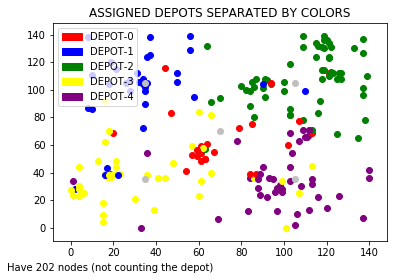

In [55]:
print( 'Instance name : '+str(filename))
print(" processing time --- %s seconds ---" % (time.time() - start_time))
util.draw_simple_assigned_depots(REQUESTS,LOCATIONS,DEPOTS,DEPOT_NUMBERS)

# Solve and print

In [50]:
results = solve_and_print(filepath)

----------------Instance name: pdp_instances/LiLim/pdp_200/LRC2_2_3.txt-----------------------------------
 processing time --- 0.16800928115844727 seconds ---


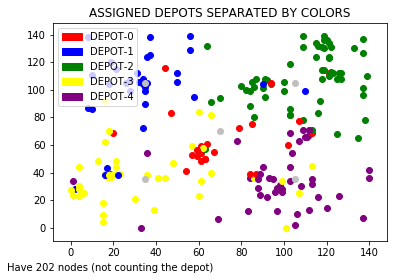

# Wrtie down the results into CSV file

In [52]:
solutions = []
cal_times = []
distances = []
for round,round_result in enumerate(results):
    sol = results[round][0]
    dist = results[round][1]   
    ct = results[round][2]
    
    
    solutions.append(sol)
    distances.append(dist)
    cal_times.append(ct)
    # for dep in range(len(sol)):
    #     sol.append(results[round][dep])
# print(sol)

print(cal_times)
        

[[11.158648490905762, 32.59378361701965, 98.10069227218628, 58.06359553337097, 51.18379759788513], [11.557669639587402, 51.73485970497131, 88.89465737342834, 85.30271553993225, 49.77076840400696]]
